# Implementing ANNs with Tensorflow
## Homework 2




### 1 Preparation
Implement a function **sigmoid(x)** and **sigmoidprime(x)**

In [1]:
import math

def sigmoid(x):
  """ Calculate the sigmoid of x

  Args:
    x (float): The value for which the sigmoid has to be calculated

  Returns:
    float: The sigmoid value of x
  """
  return 1 / (1 + math.exp(-x))

def sigmoidprime(x_act):
  """ Calculate the sigmoid derivative of x

  Args:
    x_act (float):  The activation of x (has to be calculated using the
                    sigmoid function!)
  
  Returns:
    float: The value of the sigmoid derivative of x
  """
  return x_act * (1 - x_act)

### 2 Data Set
Create an array for each logical gate (and, or, nand, nor, xor). <br>
Each array should contain all possible input for two variables and their expected output (target).

In [2]:
import numpy as np

input = list(zip([1,1,0,0], [1,0,1,0]))

label_and = [[x[0] and x[1]] for x in input]
label_or = [[x[0] or x[1]] for x in input]
label_nand = [[int(not (x[0] and x[1]))] for x in input]
label_nor = [[int(not (x[0] or x[1]))] for x in input]
label_xor = [[int(x[0] != x[1])] for x in input]

### 3 Perceptron
Create a Perceptron class. <br>
It should have the classes **forward_step(self, input)** and **update(self, delta)**

In [3]:
class Perceptron:
  def __init__(self, input_units):
    """ Creates a Perceptron and its weights (randomly initialized)
        The weights will include the weight of the bias

    Args:
        input_units (int):  The amount of perceptrons in the previous layer
                            connected to this perceptron
    """
    self.input_units = input_units
    self.alpha = 0.01
    self.weights = np.random.randn(self.input_units + 1)

  def forward_step(self, input):
    """ Computes the outputs of the perceptron 

    Args: 
      input (ndarray):  One dimensional array, that includes all outputs of
                        the previous layer. (1 is prepended to the input later
                        to account for the bias)
    Returns:
      float: The activation of this perceptron
    """
    return sigmoid(np.dot(np.concatenate(([1], input)), self.weights))

  def update(self, gradient):
    """ Updates the weights of the neuron using the gradient and the learning rate

    Args:
      gradient (ndarray): The gradient of the error signal (formed as a array,
                          because the error signal can be multi dimensional,
                          therefore each element corresponds to one weight dimension)
    """
    self.weights -= self.alpha * gradient

### 4 Multi-Layer Perceptron
Create a MLP class that can perform forward and backprop-steps. <br>
Initialize it with 1 hidden layer that has 4 Perceptrons and one output neuron.

In [4]:
class MLP:
  def __init__(self, layers, threshold):
    """ Initializes a Multi-Layer Perceptron.

    Args:
      layers (list):  One dimensional integer list where each element 
                      corresponds to a layer and the value defines 
                      the amount of neurons in the layer
      threshold (float):  The activation of the output layers perceptrons has to
                          be bigger than this value to return a 1 (otherwise it will return 0)
    """
    self.threshold = threshold

    # The input layer will be filled with placeholder values, as it is not a perceptron
    # but having it makes the indice notations later way more sensible
    self.layers = [[0] * layers[0]]

    # Creates the requested amount of perceptrons in each layer (except for the input layer)
    # and sets the input units of each perceptron to the amount of perceptrons in the previous layer
    for i, perceptrons_per_layer in enumerate(layers[1:]):
      self.layers.append([Perceptron(layers[i]) for _ in range(perceptrons_per_layer)])

  def forward_step(self, input):
    """ Computes the whole forward step

    Args:
      input (list): The input of the MLP
    
    Returns:
      list: The outputs of each layer in the MLP (stored in a ndarray containing
            the activations of all neurons in the corresponding layer)
    """
    outputs = [np.array(input)]
    for l in self.layers[1:]:
      outputs.append(np.array([p.forward_step(outputs[-1]) for p in l]))

    return outputs

  def backprop_step(self, outputs, targets):
    """ Performs backpropagation on the whole NLP

    Args:
      outputs (list): The outputs of each layer in the MLP (stored in a ndarray 
                      containing the activations of all neurons in the corresponding layer)
      targets (list): The expected output of the whole MLP
    """
    deltas = [0] * len(self.layers)

    # Loop through all layers in reversed order
    for i, layer in reversed(list(enumerate(self.layers[1:], 1))):
      deltas_layer = []

      # Loop through all perceptrons in the layer
      for j, perceptron in enumerate(layer):
        # Calculate the error signal of the output layer
        if i == len(self.layers) - 1:
          delta = (-targets[j] + int(outputs[i][j] > self.threshold)) * sigmoidprime(outputs[i][j]) / len(layer)

        # Calculate the error signal for the hidden layer(s)
        else:
          prev_layer = self.layers[i + 1]
          delta = sum([deltas[i + 1][k] * prev_layer[k].weights[j + 1] for k in range(len(prev_layer))]) * sigmoidprime(outputs[i][j])

        # Calculate the gradient of the error signal using delta and the activation
        # of the previous layer (add 1 to account for the bias)
        gradient = delta * np.concatenate(([1], [outputs[i - 1][k] for k in range(len(self.layers[i - 1]))]))

        # Update the perceptron using the gradient
        perceptron.update(gradient)
        deltas_layer.append(delta)
      
      deltas[i] = np.array(deltas_layer)

In [5]:
# Create the MLP requested in the excercise
logic_MLP = MLP([2, 4, 1], 0.5)

### 5 Training
Create a instance of the MLP and train it for 1000 epochs

In [6]:
def train_MLP(layers, threshold, epochs, input, targets):
  """ Train the MLP

  Args:
    layers (list):  One dimensional integer list where each element 
                    corresponds to a layer and the value defines 
                    the amount of neurons in the layer
    threshold (float):  The activation of the output layers perceptrons has to
                        be bigger than this value to return a 1 (otherwise it will return 0)
    epochs (int): The number of epochs the MLP should be trained
    input (list): a list of all the inputs that are fed into the MLP
    targets (list): a list of all the correct outputs the MLP should produce
                    (length=length(input))
    
  Returns:
    int: The number of epochs
    list: The loss of each epoch
    list: The accuracy of each epoch
  """
  logic_MLP = MLP(layers, threshold)

  avg_loss = []
  accuracy = []

  for e in range(epochs):
    results = []
    for (i, t) in zip(input, targets):
      # Perform the forward step with the current input
      outputs = logic_MLP.forward_step(i)

      # Add the end result of the forward step to the results (which will be used
      # to measure accuracy and loss)
      results.append(outputs[-1] > threshold)

      # Perform the backpropagation step using the outputs of the forward step
      # and the targets of the current input
      logic_MLP.backprop_step(outputs, t)

      # # Print the results after every 100 steps
      # if e % 100 == 0:
      #   print(f"{i, t, [int(o > 0.5) for o in outputs[-1]]}")
    
    # Calculate the loss and accuracy of the current epoch
    avg_loss.append(sum([(t - y)**2 for (t, y) in zip(targets, results)]) / len(input))
    accuracy.append(sum([t == y for (t, y) in zip(targets, results)])/len(input))
  
  return epochs, avg_loss, accuracy


### 6 Visualization
Create two graphs showing the avg-loss and accuracy per epoch


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_epochs(epochs, avg_loss, accuracy, name):
  """ Plot the loss and the accuracy of the MLP over all epochs

  Args:
    epochs (int): The number of epochs the MLP was trained for
    avg_loss (list): The loss of each epoch (length = epochs)
    accuracy (list): The accuracy of each epoch (length = epochs)
    name (string): The Title of the plot
  """
  # Create a plot and create the x-axis with values 0 to the number of epochs
  plt.figure()
  x = np.linspace(0, epochs, epochs)

  plt.suptitle(f"{name}-Gate", fontsize=16, y=1.05)

  # Create the first subplot that shows the average loss
  plt.subplot(2, 1, 1)
  plt.plot(x, avg_loss, color="red");
  plt.title("Average Loss")

  # Create the second subplot that shows the accuracy
  plt.subplot(2, 1, 2)
  plt.plot(x, accuracy);
  plt.title("Accuracy")

  # Set the layout to tight, so that the labels and plots don't overlap
  plt.tight_layout()
  

  plt.show()

  # Print out the final accuracy and avg_loss values
  print(f"Final Average Loss: {float(avg_loss[-1])} \nFinal Accuracy: {float(accuracy[-1])}")

### Running Training and Visualization together

Disclaimer: Due to random initialisation there is a small chance that the MLP will not converge in 1000 epochs. <br>
When training five MLPs after each other the chance of having one or more that don't converge gets quite high. <br><br>

Therefor we implemented an loop that trains the MLP until it converges. <br>
In case the network fails, it will inform you how often it did all together <br><br>
You can also train the networks without "cheating": The Line of code is commented out, but if you uncomment it and comment out everything until the last line you can get the uncensored version of the training.

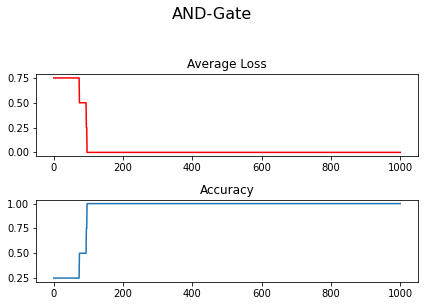

Final Average Loss: 0.0 
Final Accuracy: 1.0

Training of the AND-Gate failed 1 time




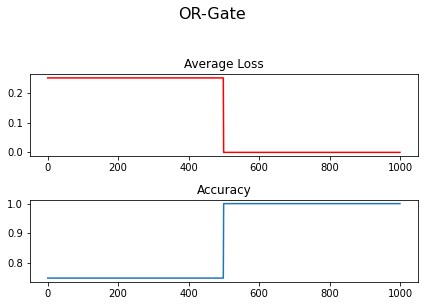

Final Average Loss: 0.0 
Final Accuracy: 1.0




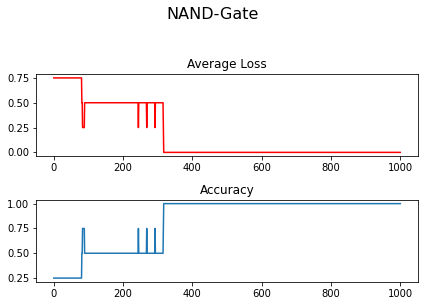

Final Average Loss: 0.0 
Final Accuracy: 1.0

Training of the NAND-Gate failed 1 time




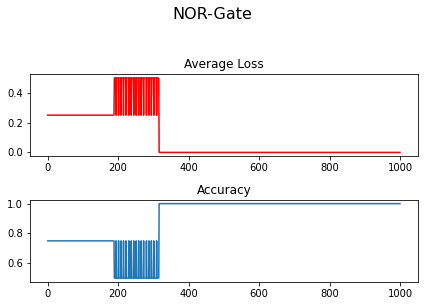

Final Average Loss: 0.0 
Final Accuracy: 1.0




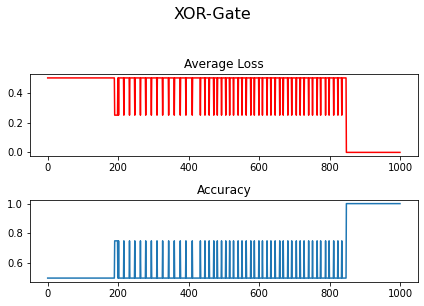

Final Average Loss: 0.0 
Final Accuracy: 1.0

Training of the XOR-Gate failed 5 times




In [8]:
# The MLP will have 2 input perceptrons, 4 perceptrons in the hidden layer and
# one output neuron. The threshold is 0.5. Its trained over 1000 full epochs.
# It will learn to map all combinations of two booleans to each kind of gate.

# Loop through all logic gate labels
for name, label in [("AND", label_and), ("OR", label_or), ("NAND", label_nand), ("NOR", label_nor), ("XOR", label_xor)]:
  # Feed the output of the training function into the plotting function 
  # (the * unpacks the tuple returned by the training funtion)
  
  # plot_epochs(*train_MLP([2, 4, 1], 0.5, 1000, input, label), name)

  # We use these lines of code instead of the one above to only print converged MLPs
  failed = True
  failed_count = 0

  # Train the MLP until it converges (count the number of failed trials)
  while(failed):
    train_data = train_MLP([2, 4, 1], 0.5, 1000, input, label)
    if (float(train_data[1][-1]) == 0.0 and float(train_data[2][-1]) == 1.0):
      failed = False
    else:
      failed_count += 1

  # Plot the MLP
  plot_epochs(*train_data, name)

  # Be transparent and show how often training failed (if it did)
  if(failed_count > 0):
    print(f"\nTraining of the {name}-Gate failed {failed_count} time" + ("" if failed_count == 1 else "s"))
  
  print("\n")